In [23]:
from tqdm import tqdm
import pickle
import random
import numpy as np

from time import sleep
from collections import defaultdict
from grid import Grid, RandomGridGenerator

from IPython.display import clear_output
from utils import two_int_to_hash, numpy_arr_to_str, approximate_5x5_to_3x3

import matplotlib.pyplot as plt

In [24]:
# GLOBAL CONFIGS
GRID_NUMBER_OF_ROWS = 200
GRID_NUMBER_OF_COLS = 200

PREDATOR_VISION_DIST = 3
PREY_VISION_DIST = 2

PREDATOR_VALUE = 2
PREY_VALUE = 1

PREDATOR_APPROXIMATE_SHARE = 0.05
PREY_APPROXIMATE_SHARE = 0.95

PREDATOR_DEFAULT_HEALTH = 200
PREY_DEFAULT_HEALTH = 10000

alpha = 0.1
gamma = 0.6
epsilon = 0.1

action_space = [
    "up",
    "down",
    "left",
    "right",
    "stay",
]


action_idxs = [0,1,2,3,4]


with open("DL_pretrained_model/predator_q_table.pickle", "rb") as f:
    pre_trained_data_predator = pickle.load(f)

    
with open("DL_pretrained_model/prey_q_table.pickle", "rb") as f:
    pre_trained_data_prey = pickle.load(f)


In [25]:
class AgentNet:
    def __init__(self, _type):
        self.q_table = dict()
        self._type = _type

    def choose_next_cell(self, state, _next):
        if state.shape[0] == 5:
            state = approximate_5x5_to_3x3(state)

        hashed_state = numpy_arr_to_str(state)

        if hashed_state not in self.q_table:
             self.q_table[hashed_state] = self._get_default_knowledge(hashed_state)

        allowed_actions = self._get_allowed_actions(_next)
        if random.uniform(0, 1) < epsilon:
            return random.choice(allowed_actions)
        else:
            return np.where(self.q_table[hashed_state]==np.max(self.q_table[hashed_state][allowed_actions,]))[0][0]

    def _get_allowed_actions(self, _next):
        actions = []
        if self._type == "prey":
            allowed_options = (0,)
        else:
            allowed_options = (0,1)
            
        if _next[1][1] in allowed_options:
            actions.append(4)

        if _next[0][1] in allowed_options:
            actions.append(0)

        if _next[2][1] in allowed_options:
            actions.append(1)

        if _next[1][0] in allowed_options:
            actions.append(2)

        if _next[1][2] in allowed_options:
            actions.append(3)

            
        if len(actions) == 0:
            print(f"No action available, a {_type} died")

        return actions

    def _get_default_knowledge(self, hashed_state):
        if self._type == "predator":
            val = pre_trained_data_predator[hashed_state]
        elif self._type == "prey":
            val = pre_trained_data_prey[hashed_state]

        else:
            raise Exception(f"Invalid type {_type}")
        return np.array(
            [
            val[1],
            val[3],
            val[4],
            val[2],
            val[0],])

In [26]:
predator_net = AgentNet("predator")
prey_net = AgentNet("prey")

In [27]:
class Animal:
    __slots__ = "last_move", "remaining_life", "_type"
    def __init__(self, remaining_life, _type):
        self.last_move = None
        self.remaining_life = remaining_life
        self._type = _type

    def process_epoch(self):
        self.remaining_life -= 1

    def move(self, vision_matrix, _next):
        if self._type == PREDATOR_VALUE:
            return predator_net.choose_next_cell(vision_matrix, _next)
        elif self._type == PREY_VALUE:
            return prey_net.choose_next_cell(vision_matrix, _next)

In [28]:
def get_dest_from_action(action, row, col):
    action = action_space[action]
    if action == "down":
        return (row+1) % GRID_NUMBER_OF_ROWS, col

    elif action == "up":
        return (row-1) % GRID_NUMBER_OF_ROWS, col

    elif action == "left":
        return row, (col-1)%GRID_NUMBER_OF_COLS

    elif action == "right":
        return row, (col+1)%GRID_NUMBER_OF_COLS

    elif action == "stay":
        return row, col

    else:
        raise Exception(f"Action can't be {action}")
    
def grid_of_nums_to_objects(grid: Grid) -> np.array:
    new_grid = np.empty(grid.grid.shape, dtype=object)
    for rowidx, row in enumerate(grid.grid):
        for colidx, val in enumerate(row):
            if val == PREDATOR_VALUE:     
                new_grid[rowidx][colidx] = Animal(PREDATOR_DEFAULT_HEALTH, PREDATOR_VALUE)
            elif val == PREY_VALUE:
                new_grid[rowidx][colidx] = Animal(PREY_DEFAULT_HEALTH, PREY_VALUE)

    return new_grid


# Main

In [29]:
rgg = RandomGridGenerator(GRID_NUMBER_OF_ROWS, GRID_NUMBER_OF_COLS)
generated_grid = rgg.getGrid(round(PREDATOR_APPROXIMATE_SHARE * 100) * [PREDATOR_VALUE] + round(PREY_APPROXIMATE_SHARE * 100) * [PREY_VALUE])

In [30]:
history = []

grid = Grid(generated_grid)  # Grid object containing the generated grid
object_grid = grid_of_nums_to_objects(grid)   # Same grid but instead of numbers objects are used
prey_c = []
pred_c = []

rewards = []  # List for keeping the rewards for each timestamp

for time in tqdm(range(1000)):

    # Variables for keeping the cumulative rewards in the current timestamp
    cumulative_reward_predator = 0  
    cumulative_reward_prey = 0  

    # Empty grids for keeping future states
    next_grid = np.zeros((grid.rown, grid.coln), dtype=np.int64)
    next_object_grid = np.empty(object_grid.shape, dtype=object)

    # Iteration over each item of the grid to move preys
    for row, line in enumerate(grid.grid):
        for col, item in enumerate(line):
            if item == PREY_VALUE:
                prey: Animal = object_grid[row][col]
                prey.process_epoch()  # Decrease remaining life by 1

                # If no life left the prey is removed from both grids
                if prey.remaining_life == 0:
                    grid.grid[row][col] = 0
                    object_grid[row][col] = None
                    continue

                # Prey will always stop at every 4-th step
                if time % 4 != 0:
                    vision_space = grid.getNeighbors(row, col, PREY_VISION_DIST)

                    action = prey.move(vision_space, grid.getNeighborsFromNext(next_grid, row, col, PREY_VISION_DIST))

                    dest = get_dest_from_action(action, row, col)
                    next_grid[dest[0], dest[1]] = item
                    next_object_grid[dest[0], dest[1]] = prey

                else:
                    next_grid[row, col] = item
                    next_object_grid[row, col] = prey


    # Iteration over each item of the grid to move predators
    for row, line in enumerate(grid.grid):
        for col, item in enumerate(line):
            if item == PREDATOR_VALUE:

                predator: Animal = object_grid[row][col]
                predator.process_epoch() # Decrease remaining life by 1

                # If no life left the predator is removed from both grids
                if predator.remaining_life == 0:
                    grid.grid[row][col] = 0
                    object_grid[row][col] = None
                    continue

                reward = 0
                vision_space = grid.getNeighbors(row, col, PREDATOR_VISION_DIST)
                action = predator.move(vision_space, grid.getNeighborsFromNext(next_grid, row, col, PREY_VISION_DIST))

                # Reward for eating a prey
                dest = get_dest_from_action(action, row, col)
                if next_grid[dest[0], dest[1]] == PREY_VALUE:
                    reward = 1
                    predator.remaining_life += 100

                cumulative_reward_predator += reward

                app_next_vs = approximate_5x5_to_3x3(grid.getNeighborsFromNext(next_grid, dest[0], dest[1], PREDATOR_VISION_DIST))
                app_vs = approximate_5x5_to_3x3(vision_space)

                if predator_net.q_table.get(numpy_arr_to_str(app_next_vs)) is None:
                    predator_net.q_table[numpy_arr_to_str(app_next_vs)] = predator_net._get_default_knowledge(numpy_arr_to_str(app_next_vs))

                max_value = np.max(predator_net.q_table[numpy_arr_to_str(app_next_vs)])
                new_q_value = (1 - alpha) * predator_net.q_table[numpy_arr_to_str(app_vs)][action] + alpha * (reward + gamma * max_value)

                predator_net.q_table[numpy_arr_to_str(app_vs)][action] = new_q_value

                next_grid[dest[0], dest[1]] = item
                next_object_grid[dest[0], dest[1]] = predator

    history.append(next_grid)

    grid = Grid(next_grid)
    object_grid = next_object_grid


    prey_count = np.count_nonzero(grid.grid == PREY_VALUE)
    pred_count = np.count_nonzero(grid.grid == PREDATOR_VALUE)
    prey_c.append(prey_count)
    pred_c.append(pred_count)

    try:
        rewards.append([pred_count, cumulative_reward_predator/pred_count])
    except:
        rewards.append([pred_count, 0])

    if pred_count == 0:
        print("no more animals on the grid")
        break

100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]


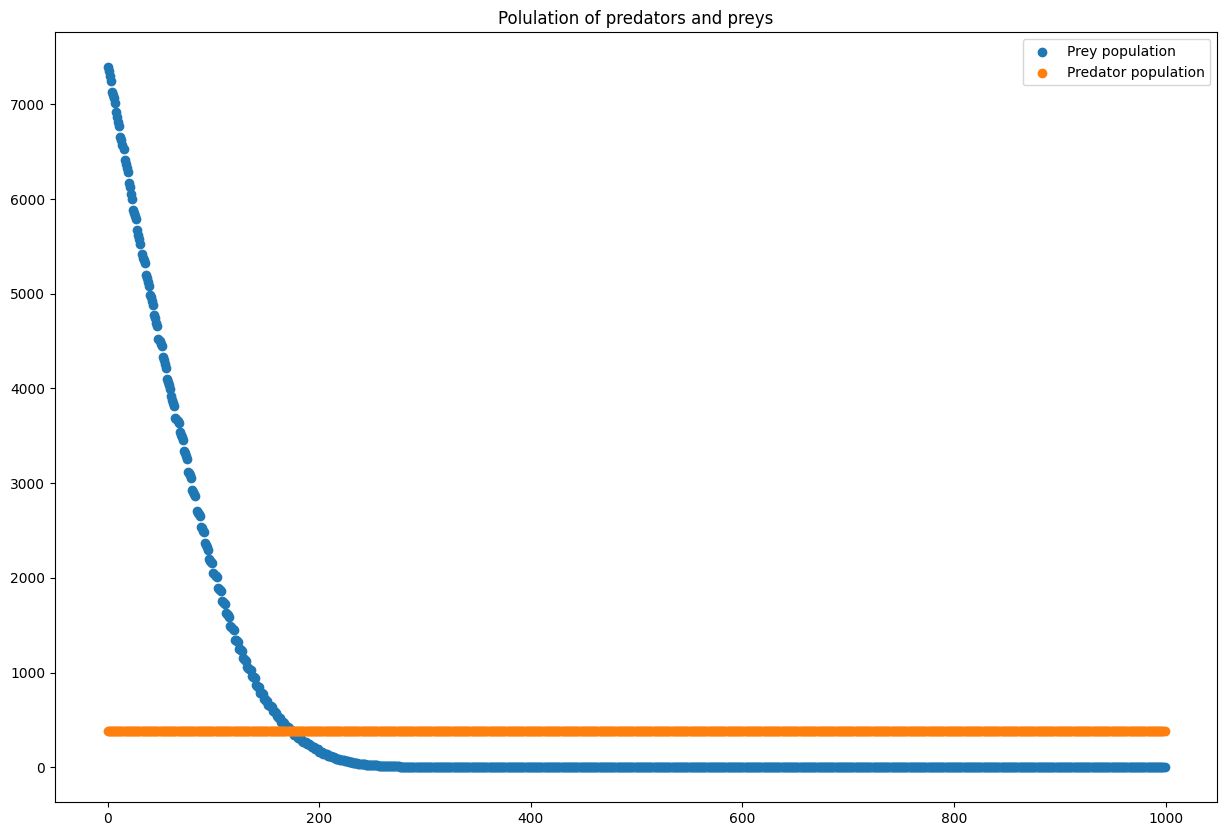

In [31]:
plt.figure(figsize=(15, 10))
plt.title("Polulation of predators and preys")
plt.scatter(list(range(len(pred_c))), prey_c, label='Prey population')
plt.scatter(list(range(len(pred_c))), pred_c, label='Predator population')
plt.legend(loc='upper right')
plt.show()

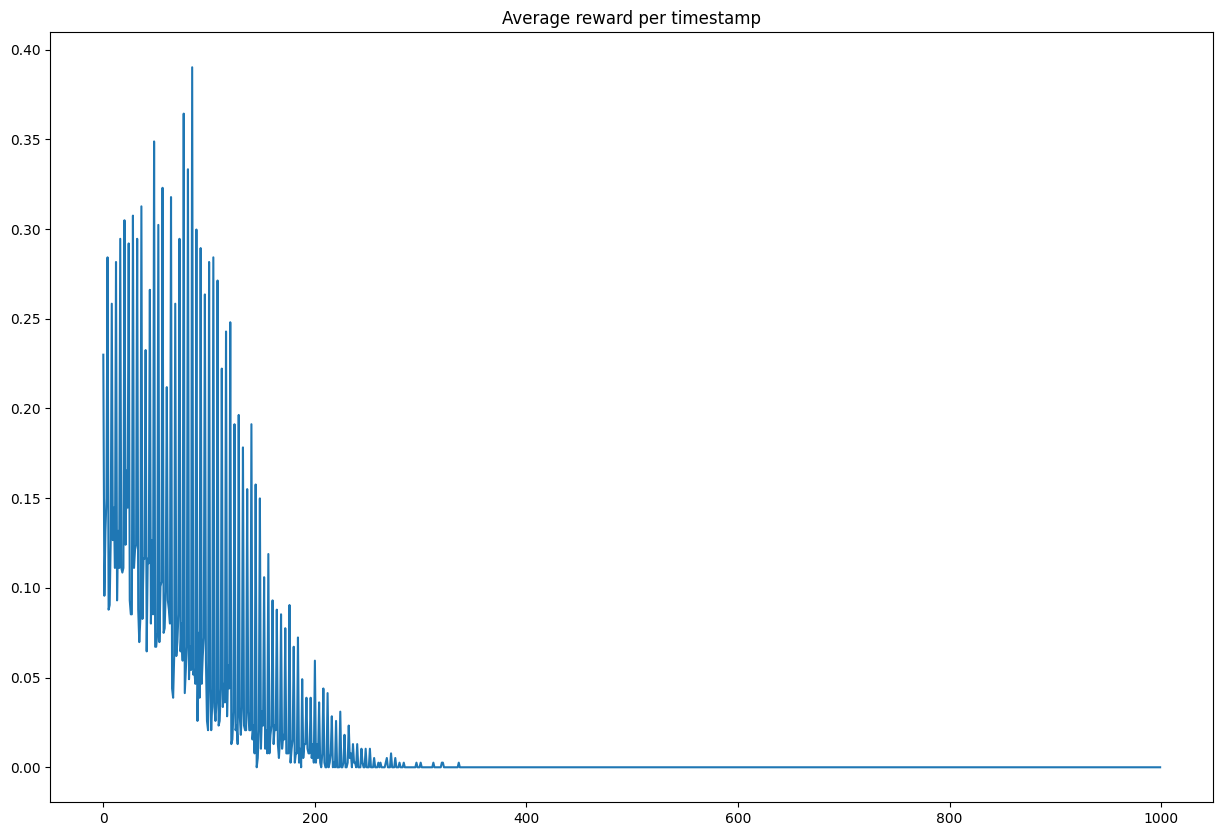

In [32]:
plt.figure(figsize=(15, 10))
plt.title("Average reward per timestamp")
plt.plot([val[1] for val in rewards])

In [33]:
import json

list_history = [el.tolist() for el in history]
with open("history.json", "w") as f:
    json.dump(list_history, f)